In [1]:
from src.model.shap.run_shap import run_shap

shap_explanations = run_shap(
    dataset_name="demographic+digital",
    target_col="group",
    task="classification",
    model_name_to_explain="SVC",
    timestamp="2025-09-12_1559"
)

/home/gianluca/Research/tmt-analysis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers.

In [2]:
shap_explanations[0].values.shape

(1, 20, 2)

In [18]:
import shap


def extract_positive_class_explanations(explanations):
    positive_class_explanations = []

    for explanation in explanations:
        vals = explanation.values.copy()
        base = explanation.base_values.copy()
        positive_class_idx = 1
        # Caso 1: (n_samples, n_classes, n_features)
        if vals.ndim == 3 and vals.shape[1] == 2:
            vals = vals[:, positive_class_idx, :]
            base = base[:, positive_class_idx] if base.ndim == 2 else base

        # Caso 2: (n_samples, n_features, n_classes)
        elif vals.ndim == 3 and vals.shape[2] == 2:
            vals = vals[:, :, positive_class_idx]
            base = base[:, positive_class_idx] if base.ndim == 2 else base

        positive_class_explanation = shap.Explanation(
            values=vals,
            base_values=base,
            data=explanation.data,
            feature_names=explanation.feature_names
        )

        positive_class_explanations.append(positive_class_explanation)

    return positive_class_explanations


In [19]:
positive_class_explanations = extract_positive_class_explanations(shap_explanations)
positive_class_explanations

[.values =
 array([[-0.02841402,  0.00256862, -0.00823842, -0.00495456, -0.00809279,
         -0.0104945 ,  0.04862322, -0.00230373,  0.0208153 , -0.00460962,
          0.0031431 ,  0.05347718, -0.00239226, -0.006643  , -0.00307571,
          0.06770231, -0.01478016, -0.01080193,  0.02321736,  0.00434233]])
 
 .base_values =
 array([0.51942199])
 
 .data =
 array([[ 1.22870466,  0.49057918, -0.83894   , -0.0395364 ,  0.14298255,
          0.62999382, -0.69400903,  0.62892401,  0.70820402,  0.0282486 ,
          0.50892069,  1.80972832,  0.51196432, -1.0600834 , -0.59419224,
         -1.22383699,  0.5049662 , -1.12254671, -0.34409597,  0.45018772]]),
 .values =
 array([[-0.04289899, -0.01027614, -0.01199514, -0.01464824, -0.01448331,
         -0.01162413, -0.01595479, -0.00121686, -0.00384525, -0.01018287,
          0.01200351, -0.02532858,  0.01198972, -0.01223657, -0.02126544,
         -0.01346013, -0.02067065,  0.00902367, -0.0758738 , -0.0094723 ]])
 
 .base_values =
 array([0.55257

In [20]:

import pandas as pd
import numpy as np

def build_shap_absolute_df(explanations):
    # Lista de dicts: {feature: abs(shap)}
    rows = []

    for expl in explanations:
        absolute_values = np.abs(expl.values)  # (1, n_features)
        names = expl.feature_names
        # Armo dict con valores de este fold
        row = dict(zip(names, absolute_values.flatten()))
        rows.append(row)

    # DataFrame folds × features (NaN si el feature no apareció en ese fold)
    df = pd.DataFrame(rows)
    return df

In [21]:
df = build_shap_absolute_df(positive_class_explanations)
df


,average_duration_PART_B,distance_difference_from_ideal_PART_A,hesitation_time_PART_A,intra_target_time_PART_A,max_duration_PART_B,non_cut_correct_targets_touches_PART_A,non_cut_correct_targets_touches_PART_B,non_cut_rt_PART_A,non_cut_rt_PART_B,rt_PART_A,...,average_duration_B_A_ratio,average_duration_PART_A,search_avg_speed_PART_B,max_duration_B_A_ratio,travel_distance_B_A_ratio,is_valid_sum_A,state_transitions_PART_A,search_time_PART_A,total_hesitations_PART_A,travel_time_PART_B
0,0.028414,0.002569,0.008238,0.004955,0.008093,0.010495,0.048623,0.002304,0.020815,0.004610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.042899,0.010276,0.014648,0.014483,0.015955,0.001217,0.003845,0.010183,0.012004,0.025329,...,0.021265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001848,0.009058,0.068297,0.002155,0.008396,0.051676,0.056577,0.003028,0.009342,0.015688,...,0.009600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.017022,0.008197,0.009869,0.010480,0.029508,0.014278,0.056805,0.004611,0.037134,0.000864,...,0.001628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.006003,0.006613,0.004127,0.001854,0.007984,0.005883,0.076260,0.008934,0.013486,0.002778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.007330,0.002704,0.003582,0.009384,0.004460,0.009103,0.012516,0.006903,0.017577,0.004230,...,0.001937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,0.067362,0.001679,0.006897,0.004036,0.058914,0.032103,0.047866,0.001321,0.035769,0.002152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,0.016320,0.009090,0.009044,0.006503,0.000498,0.016455,0.053140,0.002987,0.015610,0.002768,...,0.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,0.008735,0.006158,0.007330,0.005630,0.007280,0.033859,0.042046,0.008237,0.009702,0.004568,...,0.013437,NaN,NaN,NaN,NaN,0.086952,NaN,NaN,NaN,NaN


In [22]:
# Frecuencia de aparición (proporción de folds donde no es NaN)
freq = df.notna().mean()

# Promedio condicional (solo folds con valor, ignora NaN)
mean_cond = df.mean(skipna=True)

# Resultado combinado
result = pd.DataFrame({
    "mean_abs_shap_cond": mean_cond,
    "freq_selection": freq
}).sort_values("mean_abs_shap_cond", ascending=False)

result

,mean_abs_shap_cond,freq_selection
is_valid_sum_A,0.067039,0.094595
non_cut_correct_targets_touches_PART_B,0.041691,1.000000
max_duration_B_A_ratio,0.040831,0.027027
is_valid_sum_B,0.039191,1.000000
total_hesitations_PART_A,0.033072,0.013514
non_cut_correct_targets_touches_B_A_ratio,0.032530,1.000000
state_transitions_PART_A,0.029945,0.027027
travel_distance_B_A_ratio,0.028303,0.054054
travel_time_PART_B,0.027734,0.013514
average_duration_PART_A,0.021791,0.027027


In [15]:
import matplotlib.pyplot as plt

def plot_shap_summary(df, top_n=20):
    """
    Plotea el DataFrame resultante de shap_mean_conditional.

    Args:
        df: DataFrame con columnas ['mean_abs_shap_cond', 'freq_selection'].
        top_n: cuántos features mostrar (ordenados por mean_abs_shap_cond).
    """
    # Ordenar y limitar al top_n
    df_plot = df.sort_values("mean_abs_shap_cond", ascending=False).head(top_n)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Eje 1: barras de |SHAP| medio condicional
    ax1.bar(df_plot.index, df_plot["mean_abs_shap_cond"], color="steelblue", alpha=0.7)
    ax1.set_ylabel("Mean |SHAP| (condicional)", color="steelblue")
    ax1.tick_params(axis="y", labelcolor="steelblue")
    ax1.set_xticklabels(df_plot.index, rotation=45, ha="right")

    # Eje 2: frecuencia de selección
    ax2 = ax1.twinx()
    ax2.plot(df_plot.index, df_plot["freq_selection"], color="darkorange",
             marker="o", linestyle="-", linewidth=2)
    ax2.set_ylabel("Frecuencia de selección", color="darkorange")
    ax2.tick_params(axis="y", labelcolor="darkorange")
    ax2.set_ylim(0, 1)  # frecuencia en [0,1]

    plt.title("Importancia media de SHAP (clase positiva) y frecuencia de selección")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_172624/1532168778.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_plot.index, rotation=45, ha="right")


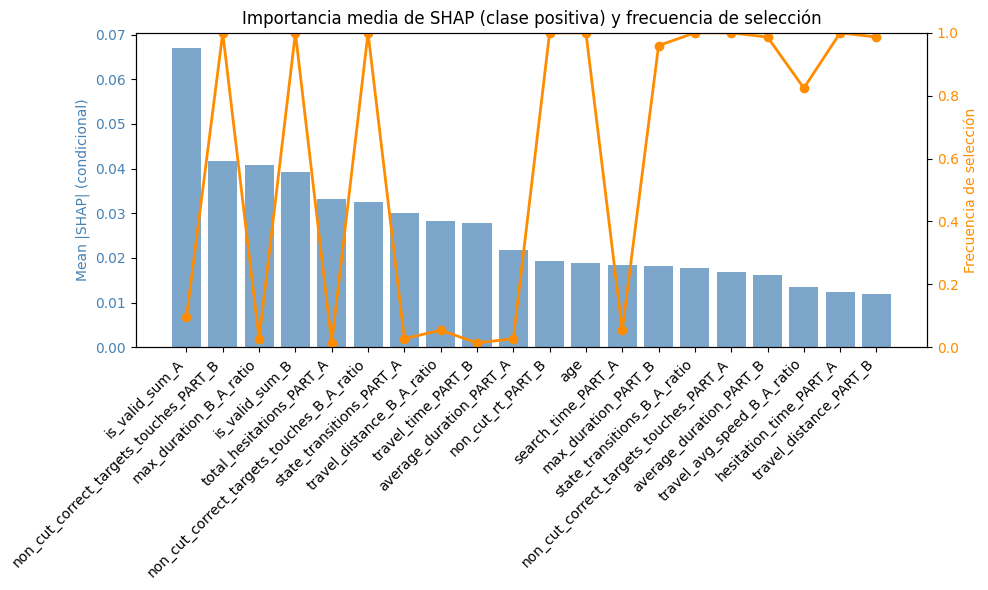

In [24]:
plot_shap_summary(result)